# 2.7 모델 세부 튜닝

## 2.7.0 이전 내용 복습

In [1]:
##############################################################################

## 데이터 추출 함수

import os
import tarfile
import urllib

DOWNLOAD_ROOT = 'https://raw.githubusercontent.com/ageron/handson-ml2/master/'
HOUSING_PATH = '../' + os.path.join('datasets', 'housing')
HOUSING_URL = DOWNLOAD_ROOT + 'datasets/housing/housing.tgz'

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    """
    현재 작업 공간에 "datasets/housing" 디렉터리 생성
    housing.tgz 파일 내려받음
    같인 디렉터리에 압축을 풀어 "housing.csv" 파일 생성
    """
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, 'housing.tgz')
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()
    
#fetch_housing_data(HOUSING_URL, HOUSING_PATH)

##############################################################################

## 데이터 읽기 함수

import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, 'housing.csv')
    return pd.read_csv(csv_path)

housing = load_housing_data()
#housing.head()

##############################################################################

## 테스트 세트 분리

import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit

# income_cat 특성 생성
housing['income_cat'] = pd.cut(housing['median_income'],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]
    
# income_cat 특성 삭제
for set_ in (strat_train_set, strat_test_set):
    set_.drop('income_cat', axis=1, inplace=True)
    
#print('strat_train_set size : {}'.format(len(strat_train_set)))
#print('strat_test_set size : {}'.format(len(strat_test_set)))

##############################################################################

## 훈련 세트 예측 변수와 레이블 분리

# drop()은 데이터 복사본을 만들며 strat_train_set에 영향을 주지 않음
housing = strat_train_set.drop('median_house_value', axis=1)
housing_labels = strat_train_set['median_house_value'].copy()

##############################################################################

## 변환 파이프 라인

# 특성 조합 변환기 정의
from sklearn.base import BaseEstimator, TransformerMixin

col_names = "total_rooms", "total_bedrooms", "population", "households"
rooms_ix, bedrooms_ix, population_ix, households_ix = [housing.columns.get_loc(c) for c in col_names]

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # *args 나 **kargs 가 아님
        self.add_bedrooms_per_room = add_bedrooms_per_room  
    def fit(self, X, y=None):
        return self # 더 이상 할 일이 없음
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix] # 가구당 방 갯수
        population_per_household = X[:, population_ix] / X[:, households_ix] # 가구당 인구수
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix] # 방 당 화장실 갯수
            return np.c_[X, 
                         rooms_per_household,
                         population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, 
                         rooms_per_household,
                         population_per_household]

# 수치형 특성 변환 파이프라인
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')), # 결측치 처리
    ('attribs_adder', CombinedAttributesAdder()), # 특성 조합
    ('std_scaler', StandardScaler()) # 수치형 특성 데이터 스케일링
])

# 통합 변환 파이프라인
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

housing_num = housing.drop('ocean_proximity', axis=1)
num_attribs = list(housing_num)
cat_attribs = ['ocean_proximity']

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', OneHotEncoder(), cat_attribs) # 범주형 특성 데이터 숫자 변환
])

housing_prepared = full_pipeline.fit_transform(housing)
#housing_prepared

##############################################################################

## 모델 훈련

# 선형 회귀
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

# 의사결정나무 - 회귀
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

# 랜덤 포레스트 - 회귀
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

# 서포트 벡터 머신
from sklearn.svm import SVR

svm_reg = SVR(kernel='linear')
svm_reg.fit(housing_prepared, housing_labels)

##############################################################################

## 평가 함수 정의

# RMSE
from sklearn.metrics import mean_squared_error
import numpy as np

def get_RMSE(model, X, y):
    predictions = model.predict(X)
    mse = mean_squared_error(y, predictions)
    rmse = np.sqrt(mse)
    return rmse

##############################################################################

## K-겹 교차 검증

from sklearn.model_selection import cross_val_score

def k_fold_cross_validation(model, X, y, cv=10):
    scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv)
    rmse_scores = np.sqrt(-scores)
    return rmse_scores

def display_scores(scores):
    print('점수:\n', scores)
    print('평균:\n', scores.mean())
    print('표준편차:\n', scores.std())

##############################################################################

## 전처리와 예측을 포함한 전체 파이프라인 및 모델 저장, 불러오기

# 전처리와 예측을 포함한 전체 파이프라인
full_pipeline_with_predictor = Pipeline([
    ('preparation', full_pipeline),
    ('linear', LinearRegression())
])

full_pipeline_with_predictor.fit(housing, housing_labels)

# 모델 저장
import joblib

my_model = full_pipeline_with_predictor
joblib.dump(my_model, '../models/my_model_ch02.pkl') # DIFF

# 모델 불러오기
my_model_loaded = joblib.load('../models/my_model_ch02.pkl')

##############################################################################

print('done')

done


In [12]:
print("linear regression's RMSE : ", get_RMSE(lin_reg, housing_prepared, housing_labels))
print("decision tree regression's RMSE : ", get_RMSE(tree_reg, housing_prepared, housing_labels))
print("randomforest regression's RMSE : ", get_RMSE(forest_reg, housing_prepared, housing_labels))
print("SVM regression's RMSE : ", get_RMSE(svm_reg, housing_prepared, housing_labels))

linear regression's RMSE :  68628.19819848923
decision tree regression's RMSE :  0.0
randomforest regression's RMSE :  22001.205898052976
SVM regression's RMSE :  111094.6308539982


In [13]:
lin_scores = k_fold_cross_validation(lin_reg, housing_prepared, housing_labels, 10)
print("linear regression's 10-fold cross validation scores:\n")
display_scores(lin_scores)

linear regression's 10-fold cross validation scores:

점수:
 [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
평균:
 69052.46136345083
표준편차:
 2731.6740017983484


In [14]:
forest_scores = k_fold_cross_validation(forest_reg, housing_prepared, housing_labels, 10)
print("randomForest regression's 10-fold cross validation scores:\n")
display_scores(forest_scores)

randomForest regression's 10-fold cross validation scores:

점수:
 [52401.63707617 50397.90294879 52122.37342201 54072.02422854
 52689.30017448 56126.4034412  50393.46220378 50781.06926795
 55699.76701831 52543.76280404]
평균:
 52722.770258526005
표준편차:
 1933.0123740301037


<br>

## 2.7.1 그리드 탐색

- 튜닝의 가장 단순한 방법
  - 만족할 만한 하이퍼파라미터 조합을 찾을 때 까지 수동으로 하이퍼파라미터를 조정하는 것
  - 사이킷런의 `GridSearchCV`를 사용하는 것이 좋다.

<br>

### 2.7.1.1 `GridSearchCV` 을 통한 그리드 탐색

- 탐색하고자 하는 하이퍼파라미터와 시도해볼 값을 지정하기만 하면 된다.
- 그러면 가능한 모든 하이퍼파라미터 조합에 대해 교차 검증을 사용해 평가하게 된다.
- 어떤 하이퍼파라미터 값을 지정해야 할 지 모를 때는 **연속된 10의 거듭제곱 수**로 시도해보는 것이 좋다.
  - 더 세밀하게 탐색하려면 아래 예제의 `n_estimators` 하이퍼파라미터처럼 더 작은 값을 지정한다.  
  
  
- `GridSearchCV`가 (기본값인) `refit=True`로 초기화되었다면, 교차 검증으로 최적의 추정기를 찾은 다음 전체 훈련 세트로 다시 훈련 시킨다.
  - 일반적으로 데이터가 많을수록 성능이 향상되므로 좋은 방법이다.

- `RandomForestRegressor`에 대한 최적의 하이퍼파라미터 조합 탐색

In [4]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}
]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg,
                           param_grid,
                           cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)
print('done')

done


<br>

- `param_grid` 설정에 따라 사이킷런이 다음과 같은 과정을 수행한다.  
  
  
1. 첫 번째 dict에 있는 `n_estimators`와 `max_features` 하이퍼파라미터의 조합인 3x4=12개를 시도한다.
2. 두 번째 dict에 있는 하이퍼파라미터 조합인 2x3=6개를 시도한다.
  - 두 번째 dict에는 `bootstrap` 하이퍼파라미터를 `True`(기본값)가 아니라 `False`로 지정한다.
3. 모두 합하면 그리드 탐색이 `RandomForestRegressor` 하이퍼파라미터 값의 18(=12+6)개 조합을 탐색하고, 각각 다섯 번 모델을 훈련시킨다.
  - `cv=5` 이기 때문에 5-겹 교차 검증을 사용  
  
  
- 최종적으로 전체 훈련 횟수는 18x5=90 이 된다.

<br>

### 2.7.1.2 최적의 조합 확인

- 90번의 훈련을 시키는 것이 시간이 꽤 오래 걸리지만 다음과 같이 최적의 조합을 얻을 수 있다.

In [16]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

- 최적의 조합의 값들이 탐색 범위의 최댓값이기 때문에 계속 점수가 향상될 가능성이 있다.
- 그러므로 더 큰 값으로 다시 검색해야 한다.

<br>

### 2.7.1.3 최적의 추정기 확인

In [17]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=8, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=30,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

<br>

### 2.7.1.4 평가 점수 확인

In [18]:
cvres = grid_search.cv_results_
sorted(list(cvres.keys()))

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'mean_train_score',
 'param_bootstrap',
 'param_max_features',
 'param_n_estimators',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split0_train_score',
 'split1_test_score',
 'split1_train_score',
 'split2_test_score',
 'split2_train_score',
 'split3_test_score',
 'split3_train_score',
 'split4_test_score',
 'split4_train_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score',
 'std_train_score']

In [19]:
pd.DataFrame(cvres)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,param_bootstrap,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.072207,0.007096,0.003397,0.000496,2,3,NaN,"{'max_features': 2, 'n_estimators': 3}",-3.716722e+09,-4.313661e+09,...,-4.116607e+09,2.563509e+08,18,-1.083079e+09,-1.047389e+09,-1.127826e+09,-1.109980e+09,-1.106520e+09,-1.094959e+09,2.772560e+07
1,0.253921,0.011312,0.011562,0.001361,2,10,NaN,"{'max_features': 2, 'n_estimators': 10}",-2.850491e+09,-3.119997e+09,...,-3.027606e+09,1.668264e+08,11,-6.173649e+08,-5.641315e+08,-5.666449e+08,-5.771149e+08,-5.799831e+08,-5.810479e+08,1.912663e+07
2,0.748794,0.035522,0.031113,0.002783,2,30,NaN,"{'max_features': 2, 'n_estimators': 30}",-2.639959e+09,-2.911493e+09,...,-2.811365e+09,1.493787e+08,8,-4.440819e+08,-4.238242e+08,-4.273691e+08,-4.469485e+08,-4.238588e+08,-4.332165e+08,1.016464e+07
3,0.136435,0.013608,0.003790,0.000399,4,3,NaN,"{'max_features': 4, 'n_estimators': 3}",-3.585587e+09,-3.762455e+09,...,-3.720020e+09,1.536307e+08,16,-1.011239e+09,-9.914131e+08,-9.562032e+08,-1.022028e+09,-9.184196e+08,-9.798606e+08,3.802849e+07
4,0.395148,0.023099,0.010778,0.000762,4,10,NaN,"{'max_features': 4, 'n_estimators': 10}",-2.674733e+09,-3.042027e+09,...,-2.838169e+09,1.510512e+08,9,-5.443797e+08,-5.544777e+08,-5.250524e+08,-5.060819e+08,-5.235322e+08,-5.307048e+08,1.698137e+07
5,1.099065,0.081386,0.026922,0.001989,4,30,NaN,"{'max_features': 4, 'n_estimators': 30}",-2.338585e+09,-2.597113e+09,...,-2.543872e+09,1.482446e+08,3,-4.018289e+08,-3.936587e+08,-3.813845e+08,-4.004283e+08,-3.855221e+08,-3.925645e+08,8.043081e+06
6,0.150803,0.008874,0.003192,0.000399,6,3,NaN,"{'max_features': 6, 'n_estimators': 3}",-3.597163e+09,-3.487085e+09,...,-3.524766e+09,1.202082e+08,14,-9.297786e+08,-8.891628e+08,-9.481490e+08,-9.182473e+08,-9.067466e+08,-9.184168e+08,2.002556e+07
7,0.503059,0.033011,0.009966,0.001099,6,10,NaN,"{'max_features': 6, 'n_estimators': 10}",-2.531234e+09,-2.723348e+09,...,-2.675294e+09,1.335638e+08,4,-5.077070e+08,-4.978420e+08,-4.958105e+08,-5.085082e+08,-4.941817e+08,-5.008099e+08,6.075659e+06
8,1.442559,0.041349,0.026115,0.002223,6,30,NaN,"{'max_features': 6, 'n_estimators': 30}",-2.322851e+09,-2.560697e+09,...,-2.486072e+09,1.252884e+08,2,-3.848096e+08,-3.722657e+08,-3.703482e+08,-3.916076e+08,-3.767458e+08,-3.791554e+08,7.973333e+06
9,0.191877,0.012946,0.004378,0.001336,8,3,NaN,"{'max_features': 8, 'n_estimators': 3}",-3.211023e+09,-3.553599e+09,...,-3.399507e+09,1.295960e+08,12,-8.762917e+08,-8.958030e+08,-8.885024e+08,-9.027841e+08,-8.944754e+08,-8.915713e+08,8.887662e+06


In [20]:
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

64160.789107027056 {'max_features': 2, 'n_estimators': 3}
55023.68549986461 {'max_features': 2, 'n_estimators': 10}
53022.30358178781 {'max_features': 2, 'n_estimators': 30}
60991.96872608704 {'max_features': 4, 'n_estimators': 3}
53274.46596407676 {'max_features': 4, 'n_estimators': 10}
50436.81299863488 {'max_features': 4, 'n_estimators': 30}
59369.73786915139 {'max_features': 6, 'n_estimators': 3}
51723.24590927607 {'max_features': 6, 'n_estimators': 10}
49860.52552881573 {'max_features': 6, 'n_estimators': 30}
58305.29360816507 {'max_features': 8, 'n_estimators': 3}
52234.69698472098 {'max_features': 8, 'n_estimators': 10}
49780.33614076912 {'max_features': 8, 'n_estimators': 30}
62113.40513981505 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54793.75392047745 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59721.59735753971 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52422.113056631315 {'bootstrap': False, 'max_features': 3, 'n_estimators': 

<br>

- 이 예에서는 `max_features=8`, `n_estimators=30` 일 때 최적의 솔루션이다.
- 이 때 RMSE 점수가 50,109로 앞서 기본 하이퍼파라미터 설정으로 얻은 50,293 보다 조금 더 좋다.

<br>

### 2.7.1.5 데이터 준비 단계에 그리드 탐색 적용

- 데이터 준비 단계를 하나의 하이퍼파라미터처럼 다룰 수 있다.
- ex) 그리드 탐색이 확실하지 않은 특성을 추가할 지 말지 자동으로 정할 수 있다.
  - `CombinedAttributedsAdder` 변환기의 `add_bedrooms_per_room` 하이퍼파라미터를 사용하여 특성을 추가할 지 결정
- 비슷하게 이상치나 값이 빈 특성을 다루거나 특성 선택 등을 자동으로 처리하는 데 그리드 탐색이 활용된다.
  - 데이터 준비 단계와 모델을 연결한 파이프라인을 그리드 탐색을 적용할 때 데이터 준비 단계를 캐싱하면 탐색 시간을 줄일 수 있다.
  - 참고 : [Pipeline에서 캐싱을 사용하기](https://goo.gl/cq9Nyb)

<br>

## 2.7.2 랜덤 선택

- 그리드 탐색 방법은 비교적 적은 수의 조합을 탐구할 때 괜찮다.
- 하지만 하이퍼파라미터 탐색 공간이 커지면 `RandomizedSearchCV`를 사용하는 편이 더 좋다.
- 특히 규제처럼 설정값이 **연속형**인 경우 랜덤 탐색이 권장된다.
  - 랜덤 탐색을 10회 반복하여 찾은 최적의 하이퍼파라미터는 `n_estimators`가 180, `max_features`가 7이다.
- `RandomizedSearchCV`는 `GridSearchCV`와 거의 같은 방식으로 사용하지만 가능한 모든 조합을 시도하는 대신 각 반복마다 하이퍼파라미터에 임의의 수를 대입하여 지정한 횟수 만큼 평가한다.
- 이 방식의 주요 장점은 다음 두 가지이다.
  - 랜덤 탐색을 1,000회 반복하도록 실행하면 하이퍼파라미터마다 각기 다른 1,000개의 값을 탐색한다.  
  (그리드 탐색에서는 하이퍼파라미터마다 몇 개의 값만 탐색한다.)
  - 단순히 반복 횟수를 조절하는 것만으로 하이퍼파라미터 탐색에 투입할 컴퓨팅 자원을 제어할 수 있다.

In [2]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.ensemble import RandomForestRegressor

param_distribs = {
    'n_estimators': randint(low=1, high=200),
    'max_features': randint(low=1, high=8)
}

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg,
                                param_distributions=param_distribs,
                                n_iter=10,
                                cv=5,
                                scoring='neg_mean_squared_error',
                                random_state=42)
rnd_search.fit(housing_prepared, housing_labels)
print('done')

done


In [3]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

49150.70756927707 {'max_features': 7, 'n_estimators': 180}
51389.889203389284 {'max_features': 5, 'n_estimators': 15}
50796.155224308866 {'max_features': 3, 'n_estimators': 72}
50835.13360315349 {'max_features': 5, 'n_estimators': 21}
49280.9449827171 {'max_features': 7, 'n_estimators': 122}
50774.90662363929 {'max_features': 3, 'n_estimators': 75}
50682.78888164288 {'max_features': 3, 'n_estimators': 88}
49608.99608105296 {'max_features': 5, 'n_estimators': 100}
50473.61930350219 {'max_features': 3, 'n_estimators': 150}
64429.84143294435 {'max_features': 5, 'n_estimators': 2}


- best params : `49150.70756927707 {'max_features': 7, 'n_estimators': 180}`

<br>

- `RandomizedSearchCV`를 위한 Scipy 분포 함수

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

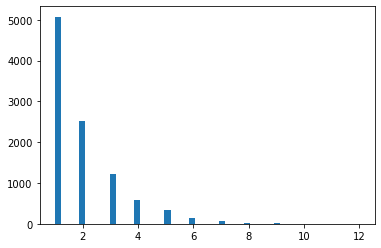

In [14]:
from scipy.stats import geom

geom_distrib = geom(0.5).rvs(10000, random_state=42)
plt.hist(geom_distrib, bins=50)
plt.show()

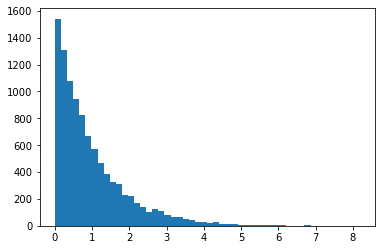

In [15]:
from scipy.stats import expon

expon_distrib = expon(scale=1).rvs(10000, random_state=42)
plt.hist(expon_distrib, bins=50)
plt.show()

<br>

## 2.7.3 앙상블 방법

- 모델을 세밀하게 튜닝하는 또 다른 방법은 **최상의 모델을 연결해보는 것**이다.
  - 결정 트리의 앙상블인 랜덤 포레스트가 결정 트리 하나보다 더 성능이 좋음
- 모델의 그룹(또는 앙상블(ensemble))이 최상의 단일 모델보다 더 나은 성능을 발휘할 때가 많다.
- 특히 **개개의 모델이 각기 다른 형태의 오차를 만들 때** 그렇다.
- 7장에서 자세히 다룸

<br>

## 2.7.4 최상의 모델과 오차 분석

- 최상의 모델을 분석하면 문제에 대한 좋은 통찰을 얻는 경우가 많다.

<br>

### 2.7.4.1 특성 중요도

- `RandomForestRegressor`가 정확한 예측을 만들기 위한 각 특성의 상대적 중요도를 알려준다.

In [5]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([6.97303211e-02, 6.54203229e-02, 4.49751385e-02, 1.48995369e-02,
       1.45590289e-02, 1.54571110e-02, 1.38542321e-02, 3.42373218e-01,
       5.67088440e-02, 1.12368626e-01, 7.78529703e-02, 6.64634793e-03,
       1.59226794e-01, 7.72169072e-05, 2.58711400e-03, 3.26317745e-03])

<br>

- 중요도와 특성 이름 함께 표시

In [6]:
extra_attribs = ['rooms_per_hhold', 'pop_per_hhold', 'bedrooms_per_room']
cat_encoder = full_pipeline.named_transformers_['cat']
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
print(attributes)

['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'rooms_per_hhold', 'pop_per_hhold', 'bedrooms_per_room', '<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN']


In [7]:
sorted(zip(feature_importances, attributes), reverse=True)

[(0.3423732180943481, 'median_income'),
 (0.1592267936887254, 'INLAND'),
 (0.11236862631360213, 'pop_per_hhold'),
 (0.0778529703294465, 'bedrooms_per_room'),
 (0.06973032114652118, 'longitude'),
 (0.06542032286785304, 'latitude'),
 (0.05670884396655083, 'rooms_per_hhold'),
 (0.044975138485792335, 'housing_median_age'),
 (0.015457110991631608, 'population'),
 (0.014899536869926231, 'total_rooms'),
 (0.01455902888980478, 'total_bedrooms'),
 (0.013854232070124957, 'households'),
 (0.006646347928268235, '<1H OCEAN'),
 (0.0032631774545039565, 'NEAR OCEAN'),
 (0.002587113995654641, 'NEAR BAY'),
 (7.721690724605114e-05, 'ISLAND')]

<br>

- 이 정보를 바탕으로 덜 중요한 특성들을 제외할 수 있다.
  - ex) `ocean_proximity` 카테고리 중 하나만 실제로 유용하므로 다른 카테고리는 제외할 수 있다.

<br>

### 2.7.4.2 오차 분석

- 시스템이 특정한 오차를 만들었다면 왜 그런 문제가 생겼는 지 이해하고 **문제를 해결하는 방법**이 무엇인 지 찾아야 한다.
  - 추가 특성 포함
  - 불필요한 특성 제거
  - 이상치 제외

<br>

## 2.7.5 테스트 세트로 시스템 평가하기

### 2.7.5.1 테스트 세트를 이용한 모델 최종 평가

- 테스트 세트에서 예측 변수와 레이블을 얻은 후 `full_pipeline`을 사용해 데이터를 변환
  - 테스트 세트에서 훈련하면 안되므로 `fit_transform()`이 아니라 `transform()`을 호출
- 테스트 세트에서 최종 모델 평가

In [8]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop('median_house_value', axis=1)
y_test = strat_test_set['median_house_value'].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

47905.4483716546

<br>

### 2.7.5.2 테스트 RMSE에 대한 95% 신뢰 구간 계산

- 어떤 경우에는 이런 일반화 오차의 추정이 론칭을 결정하기에 충분하지 않을 수 있다.
- 이 추정값이 얼마나 정확한 지 알고 싶을 때 `scipy.stats.t.interval()`를 사용해 일반화 오차의 **95% 신뢰 구간(confidence interval)**을 계산할 수 있다.

In [9]:
from scipy import stats
confidence = 0.95
squared_errors = (final_predictions - y_test)**2
np.sqrt(stats.t.interval(confidence,
                         len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([45892.48146371, 49837.17600829])

<br>

- 다음과 같이 수동으로 계산할 수도 있다.

In [10]:
m = len(squared_errors)
mean = squared_errors.mean()
tscore = stats.t.ppf((1+confidence)/2, df=m-1)
tmargin = tscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean-tmargin), np.sqrt(mean+tmargin)

(45892.48146370956, 49837.17600829304)

<br>

- 또는 t-점수 대신 z-점수를 사용할 수도 있다.

In [12]:
zscore = stats.norm.ppf((1+confidence)/2)
zmargin = zscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean-zmargin), np.sqrt(mean+zmargin)

(45893.08476618239, 49836.62045145621)

<br>

### 2.7.5.3 테스트 세트 성능 향상을 위한 하이퍼파라미터 튜닝 제한

- 하이퍼파라미터 튜닝을 많이 했다면 교차 검증을 사용해 측정한 것보다 조금 성능이 낮은 것이 보통이다.
  - 우리 시스템이 검증 데이터에서 좋은 성능을 내도록 세밀하게 튜닝되었기 때문에 새로운 데이터셋에는 잘 작동하지 않을 가능성이 크다.
- 이런 경우가 생기더라도 테스트 세트에서 성능 수치를 좋게 하려고 하이퍼파라미터를 튜닝하려 시도해서는 안된다.
- 그렇게 향상된 성능은 새로운 데이터에 일반화되기 어렵다.